In [1]:
pip show qiskit | grep Version

Version: 0.46.0
Note: you may need to restart the kernel to use updated packages.


In [1]:
import sys
sys.path.append("../src")

In [73]:
import utils
import qiskit
import numpy as np
import qiskit_aer
from bitstring import BitArray

In [3]:
data = utils.simulate_data(num_samples=8)
time_resolution = int(np.log2(len(data)))

In [52]:
angles = utils.convert_to_angles(data)

In [102]:
time_register      = qiskit.QuantumRegister(time_resolution,'t')
amplitude_register = qiskit.QuantumRegister(1,'a')
qc = qiskit.QuantumCircuit(amplitude_register,time_register)
qc.h(time_register)

In [103]:
def apply_x(qc,t,treg):
    t_bitstring = []
    for i, treg_qubit in enumerate(treg):
        t_bit = (t >> i) & 1
        t_bitstring.append(t_bit)
        if not t_bit:
            qc.x(treg_qubit)

In [104]:
def value_setting(qc, t, a, treg, areg):
    apply_x(qc, t, treg)
    mc_ry = qiskit.QuantumCircuit()
    mc_ry.add_register(areg)
    mc_ry.ry(2*a, 0)
    mc_ry = mc_ry.control(treg.size)
    qc.append(mc_ry, [i for i in range(treg.size + areg.size - 1, -1, -1)])
    apply_x(qc, t, treg)

In [105]:
for t, theta in enumerate(angles):        
    value_setting(qc, t, theta, time_register, amplitude_register)

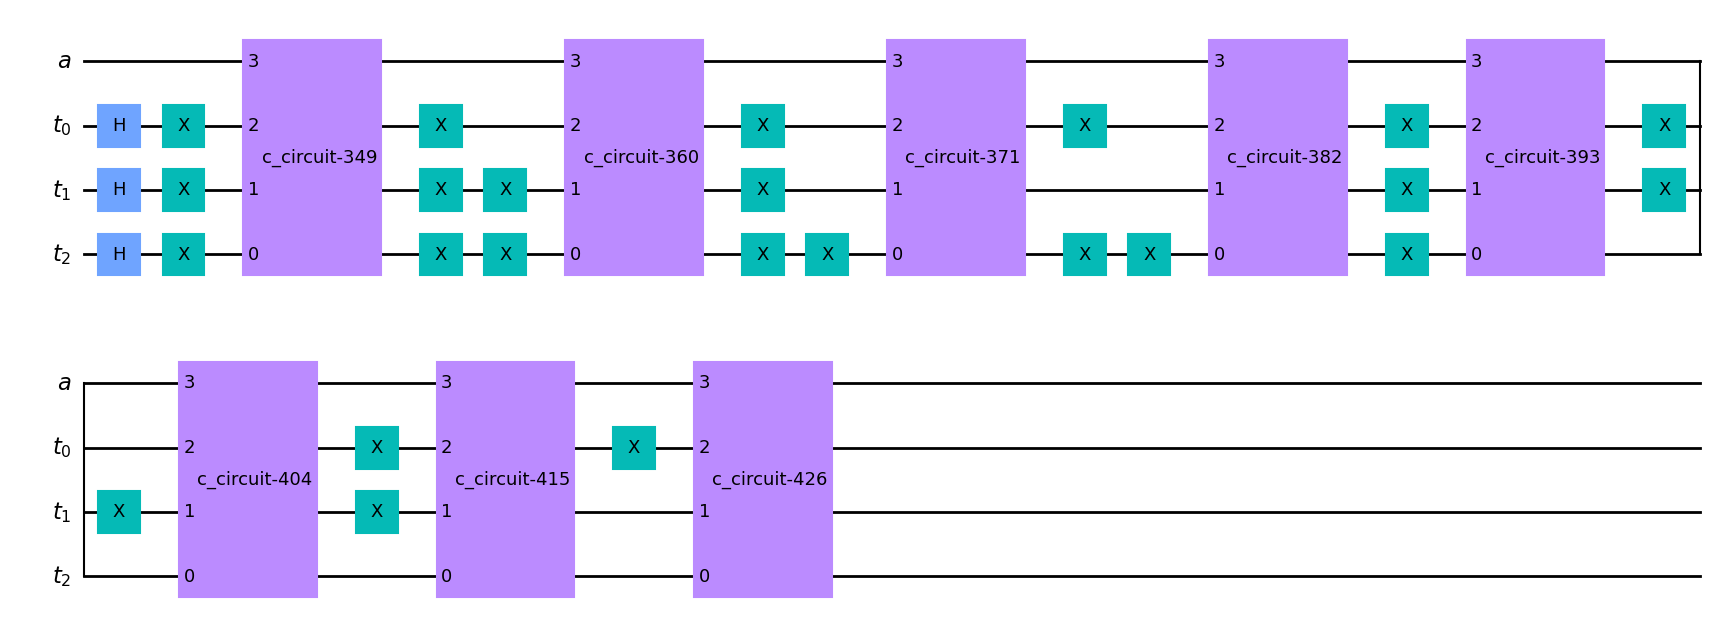

In [106]:
qc.draw('mpl',style='clifford')

In [107]:
def measure(qc, treg_pos = 1, areg_pos = 0):
    treg = qc.qregs[treg_pos]
    areg = qc.qregs[areg_pos]
       
    ctreg = qiskit.ClassicalRegister(treg.size, 'ct')
    careg = qiskit.ClassicalRegister(areg.size, 'ca')        
    qc.add_register(careg)
    qc.add_register(ctreg)
        
    qc.measure(treg, ctreg)
    qc.measure(areg, careg)

In [108]:
measure(qc)

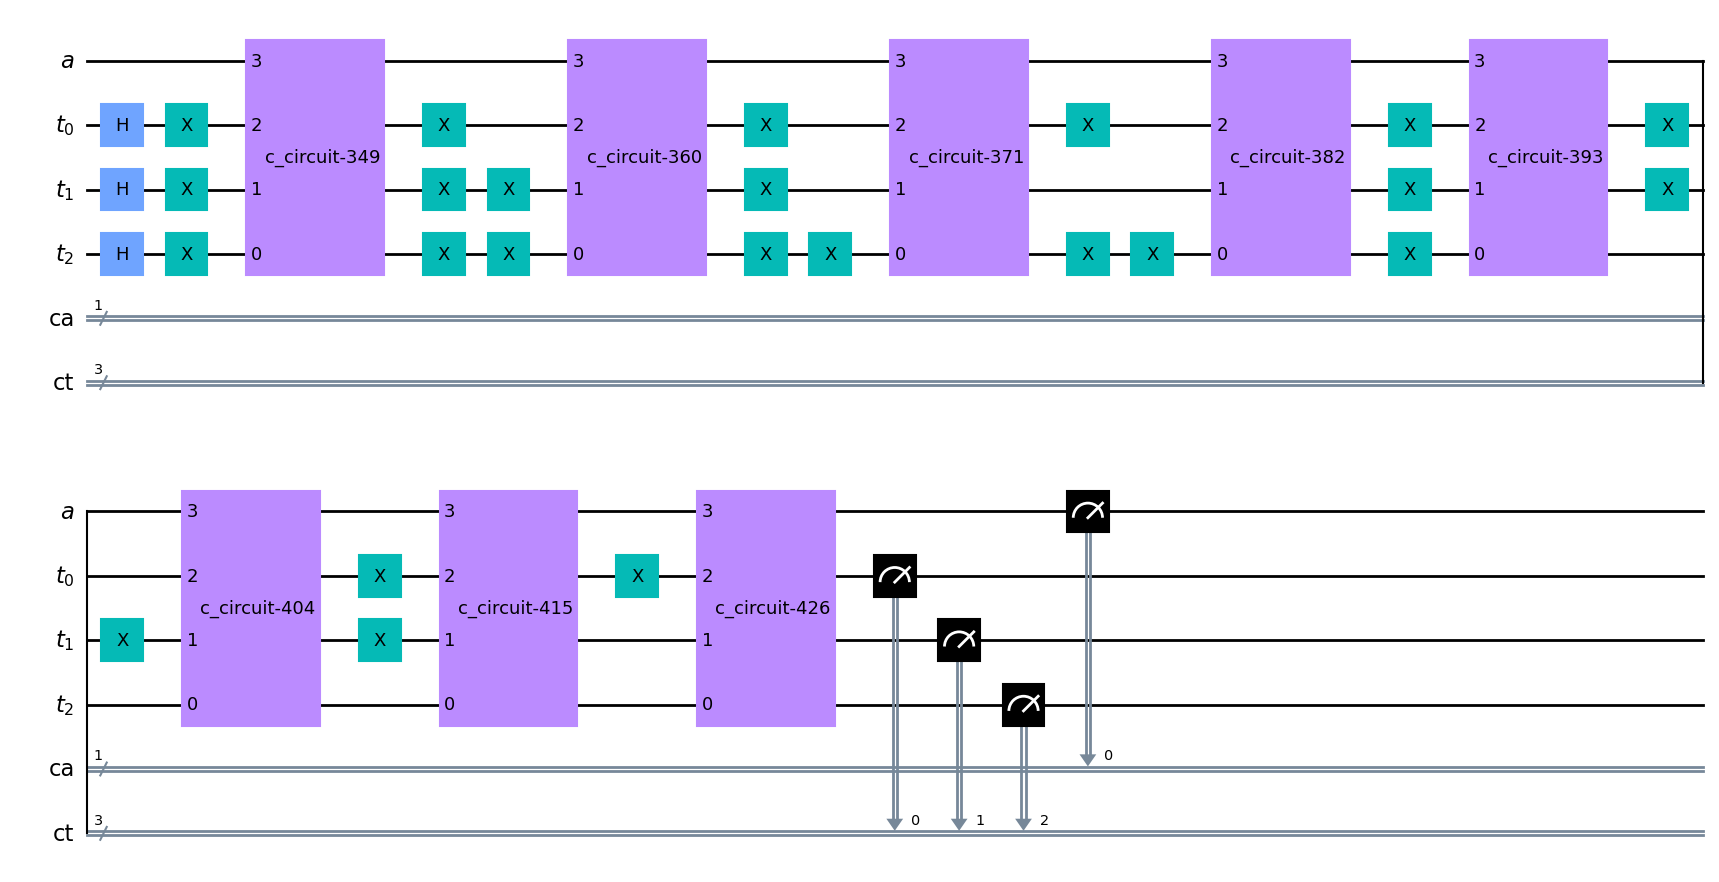

In [109]:
qc.draw('mpl',style='clifford')

In [110]:
backend = qiskit_aer.AerSimulator()
shots = 1024

In [111]:
job = qiskit.execute(qc,backend=backend,shots=1024)
counts = job.result().get_counts()

/var/folders/lq/shl3t2n51mgdksn52y8zz7t00000gn/T/ipykernel_5299/2088830272.py:1: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  job = qiskit.execute(qc,backend=backend,shots=1024)


In [115]:
def reconstruct(treg_size, counts, shots=1024):
    N = 2**treg_size
    cosine_amps = np.zeros(N)
    sine_amps = np.zeros(N)
    for state in counts:
        (t_bits, a_bit) = state.split()
        t = int(t_bits, 2)
        a = counts[state]
        if (a_bit == '0'):
            cosine_amps[t] = a
        elif (a_bit =='1'):
            sine_amps[t] = a
    return 2*(sine_amps/(cosine_amps+sine_amps))-1

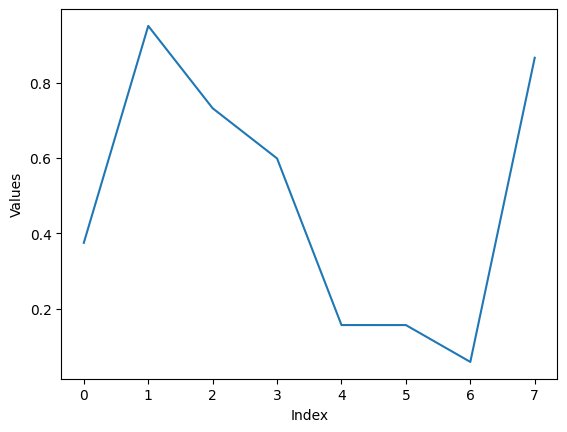

In [121]:
utils.plot(data)

/var/folders/lq/shl3t2n51mgdksn52y8zz7t00000gn/T/ipykernel_5299/1274138658.py:13: RuntimeWarning: invalid value encountered in divide
  return 2*(sine_amps/(cosine_amps+sine_amps))-1


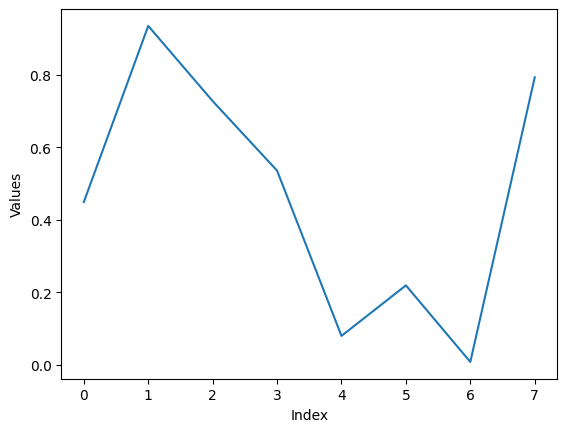

In [120]:
utils.plot(reconstruct(8,counts))